In [1]:
#dependencies
%pip -q install --upgrade google-genai faiss-cpu numpy pandas scikit-learn matplotlib gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.9/721.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [2]:
#Gemini api key
import os, getpass

if not os.environ.get("GEMINI_API_KEY"):
    os.environ["GEMINI_API_KEY"] = getpass.getpass("Paste your GEMINI_API_KEY (input hidden): ")

print("GEMINI_API_KEY set:", "✅" if os.environ.get("GEMINI_API_KEY") else "❌")


Paste your GEMINI_API_KEY (input hidden): ··········
GEMINI_API_KEY set: ✅


In [3]:
#paleisti gemini
from google import genai
from google.genai import types

client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

MODEL_ID = "gemini-2.5-flash"          # fast, good for chat
EMBED_MODEL = "gemini-embedding-001"   # embeddings model

# del greicio naudojama maziau embedding dimensiju.
EMBED_DIM = 768


In [4]:
# pavyzdinis knowledge base
kb_docs = [
    {
        "doc_id": "CC-BILL-001",
        "category": "billing",
        "title": "Refunds and chargebacks (CyberCare policy)",
        "source": "CyberCare internal policy",
        "text": (
            "CyberCare refund policy (example):\n"
            "- Verify customer identity before discussing billing.\n"
            "- If refund eligible: create a billing ticket with order ID and reason.\n"
            "- Never ask for full card numbers, passwords, or 2FA codes.\n"
            "- For disputed charges: advise customer to contact CyberCare billing; escalate if urgent.\n"
        ),
    },
    {
        "doc_id": "CC-BILL-002",
        "category": "billing",
        "title": "Common billing troubleshooting checklist",
        "source": "CyberCare runbook",
        "text": (
            "If customer reports unexpected charge:\n"
            "1) Confirm product + plan + renewal cadence.\n"
            "2) Ask for order/invoice ID or last 4 digits + date/time (never full card).\n"
            "3) Check whether it was an auto-renewal.\n"
            "4) If purchased via app store: direct to that store for billing changes.\n"
        ),
    },
    {
        "doc_id": "NORD-ACC-001",
        "category": "nordvpn_account",
        "title": "Account access help (generic flow)",
        "source": "Approved support flow (example)",
        "text": (
            "Account access help:\n"
            "- Ask for the email on the account and whether they can access it.\n"
            "- Suggest password reset via official account recovery.\n"
            "- If they cannot access the email inbox, escalate to identity verification.\n"
            "- Never request passwords or 2FA codes.\n"
        ),
    },
    {
        "doc_id": "NORD-TECH-001",
        "category": "nordvpn_technical",
        "title": "Connectivity troubleshooting (generic flow)",
        "source": "Approved support flow (example)",
        "text": (
            "Connectivity troubleshooting:\n"
            "1) Ask platform (Windows/macOS/iOS/Android) and error message.\n"
            "2) Confirm internet works without VPN.\n"
            "3) Try switching server/region and protocol.\n"
            "4) If still failing, collect logs per policy and escalate.\n"
        ),
    },
]
len(kb_docs)


4

In [5]:
# dokumentu dalinimas gabalais + embedding
import re
import numpy as np
import pandas as pd
from typing import List, Dict

def chunk_text(text: str, chunk_chars: int = 900, overlap: int = 150) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    if len(text) <= chunk_chars:
        return [text]
    chunks = []
    start = 0
    while start < len(text):
        end = min(len(text), start + chunk_chars)
        chunks.append(text[start:end])
        if end == len(text):
            break
        start = max(0, end - overlap)
    return chunks

def l2_normalize(vecs: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(vecs, axis=1, keepdims=True) + 1e-12
    return vecs / norms

def embed_texts(texts: List[str], task_type: str) -> np.ndarray:
    # Batch calls for reliability
    out = []
    B = 32
    for i in range(0, len(texts), B):
        batch = texts[i:i+B]
        result = client.models.embed_content(
            model=EMBED_MODEL,
            contents=batch,
            config=types.EmbedContentConfig(
                task_type=task_type,
                output_dimensionality=EMBED_DIM
            )
        )
        # result.embeddings is list of Embedding objects; each has .values
        out.extend([e.values for e in result.embeddings])
    vecs = np.array(out, dtype=np.float32)
    vecs = l2_normalize(vecs)  # required for cosine/IP similarity when dim != 3072
    return vecs

# Build chunk table
chunks = []
for d in kb_docs:
    for j, ch in enumerate(chunk_text(d["text"])):
        chunks.append({
            "chunk_id": f'{d["doc_id"]}::c{j:02d}',
            "doc_id": d["doc_id"],
            "category": d["category"],
            "title": d["title"],
            "source": d["source"],
            "text": ch
        })

chunks_df = pd.DataFrame(chunks)
chunks_df.head()


,chunk_id,doc_id,category,title,source,text
0,CC-BILL-001::c00,CC-BILL-001,billing,Refunds and chargebacks (CyberCare policy),CyberCare internal policy,CyberCare refund policy (example): - Verify cu...
1,CC-BILL-002::c00,CC-BILL-002,billing,Common billing troubleshooting checklist,CyberCare runbook,If customer reports unexpected charge: 1) Conf...
2,NORD-ACC-001::c00,NORD-ACC-001,nordvpn_account,Account access help (generic flow),Approved support flow (example),Account access help: - Ask for the email on th...
3,NORD-TECH-001::c00,NORD-TECH-001,nordvpn_technical,Connectivity troubleshooting (generic flow),Approved support flow (example),Connectivity troubleshooting: 1) Ask platform ...


In [6]:
# Embed all KB chunks (documents)
doc_vectors = embed_texts(chunks_df["text"].tolist(), task_type="RETRIEVAL_DOCUMENT")
doc_vectors.shape


(4, 768)

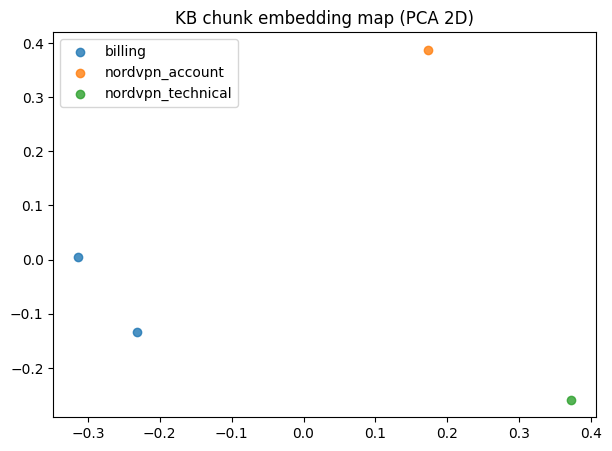

In [7]:
# KB duomenu artumo lentele
import faiss
import numpy as np
import matplotlib.pyplot as plt

index = faiss.IndexFlatIP(EMBED_DIM)  # cosine similarity if vectors normalized
index.add(doc_vectors)

def pca_2d(X: np.ndarray) -> np.ndarray:
    # X: (n, d)
    Xc = X - X.mean(axis=0, keepdims=True)
    # SVD on centered data
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    # Project onto top-2 PCs
    return Xc @ Vt[:2].T

xy = pca_2d(doc_vectors)

plt.figure(figsize=(7,5))
cats = sorted(chunks_df["category"].unique())
for cat in cats:
    m = (chunks_df["category"].values == cat)
    plt.scatter(xy[m,0], xy[m,1], label=cat, alpha=0.8)
plt.title("KB chunk embedding map (PCA 2D)")
plt.legend()
plt.show()

In [8]:
# pavyzdines Cybercare sistemos
import datetime as dt
from typing import Optional


CUSTOMERS = {
    "cust_001": {
        "customer_id": "cust_001",
        "email": "alex@example.com",
        "name": "Alex P.",
        "plan": "NordVPN Plus (Monthly)",
        "status": "active",
        "renewal_date": "2026-03-01",
    }
}

INVOICES = {
    "cust_001": [
        {"invoice_id": "inv_1001", "date": "2026-01-01", "amount": 12.99, "currency": "EUR", "status": "paid"},
        {"invoice_id": "inv_1002", "date": "2026-02-01", "amount": 12.99, "currency": "EUR", "status": "paid"},
    ]
}

TICKETS = []

def get_customer_profile(customer_id: str) -> Dict:
    return CUSTOMERS.get(customer_id, {"error": "customer_not_found"})

def get_recent_invoices(customer_id: str, limit: int = 5) -> Dict:
    invs = INVOICES.get(customer_id, [])
    return {"customer_id": customer_id, "invoices": invs[:limit]}

def create_support_ticket(category: str, summary: str, priority: str, customer_id: Optional[str] = None) -> Dict:
    ticket_id = f"t_{len(TICKETS)+1:05d}"
    ticket = {
        "ticket_id": ticket_id,
        "created_at": dt.datetime.utcnow().isoformat() + "Z",
        "category": category,
        "summary": summary,
        "priority": priority,
        "customer_id": customer_id,
        "status": "open",
    }
    TICKETS.append(ticket)
    return ticket

fn_get_customer_profile = {
    "name": "get_customer_profile",
    "description": "Fetches a CyberCare customer profile by customer_id (for verifying plan/status/renewal date).",
    "parameters": {
        "type": "object",
        "properties": {
            "customer_id": {"type": "string", "description": "CyberCare customer id, e.g., 'cust_001'."}
        },
        "required": ["customer_id"],
    },
}
fn_get_recent_invoices = {
    "name": "get_recent_invoices",
    "description": "Fetches recent CyberCare invoices for a customer.",
    "parameters": {
        "type": "object",
        "properties": {
            "customer_id": {"type": "string"},
            "limit": {"type": "integer", "description": "Max number of invoices to return."},
        },
        "required": ["customer_id"],
    },
}
fn_create_support_ticket = {
    "name": "create_support_ticket",
    "description": "Creates a CyberCare support ticket for billing/account/technical escalation.",
    "parameters": {
        "type": "object",
        "properties": {
            "category": {"type": "string", "enum": ["billing", "account", "technical", "other"]},
            "summary": {"type": "string"},
            "priority": {"type": "string", "enum": ["low", "normal", "high", "urgent"]},
            "customer_id": {"type": "string"},
        },
        "required": ["category", "summary", "priority"],
    },
}

TOOLS = types.Tool(function_declarations=[
    fn_get_customer_profile,
    fn_get_recent_invoices,
    fn_create_support_ticket,
])

TOOL_REGISTRY = {
    "get_customer_profile": get_customer_profile,
    "get_recent_invoices": get_recent_invoices,
    "create_support_ticket": create_support_ticket,
}


In [9]:
# agento kurimas
import time
import datetime as dt
import re
import pandas as pd
from google.genai import types

SENSITIVE_PATTERNS = [
    (re.compile(r"\b\d{12,19}\b"), "[REDACTED_CARD_NUMBER]"),
    (re.compile(r"(?i)\bpassword\b\s*[:=]\s*\S+"), "password: [REDACTED]"),
    (re.compile(r"(?i)\b2fa\b\s*[:=]\s*\S+"), "2fa: [REDACTED]"),
]

def redact_sensitive(text: str) -> str:
    out = text
    for pat, repl in SENSITIVE_PATTERNS:
        out = pat.sub(repl, out)
    return out

def retrieve(query: str, top_k: int = 4) -> pd.DataFrame:
    q_vec = embed_texts([query], task_type="RETRIEVAL_QUERY")
    scores, idxs = index.search(q_vec, top_k)
    rows = chunks_df.iloc[idxs[0]].copy()
    rows["score"] = scores[0]
    return rows.sort_values("score", ascending=False)

SYSTEM_INSTRUCTION = """
You are CyberCare's customer support chat assistant for NordVPN-related topics (account access, plans, renewals) and CyberCare billing.
Rules:
- You are CyberCare support, NOT NordVPN. Do not claim to represent NordVPN directly.
- Never ask for passwords, 2FA codes, or full payment card numbers.
- If identity verification is needed, ask for minimal safe info (email on account, invoice/order ID, dates, last 4 digits only).
- Use provided KB excerpts as the source of truth; if KB is insufficient, ask a clarifying question or create an escalation ticket.
- When you use KB info, cite it in-line like [KB:CHUNK_ID].
- Keep responses concise and procedural (steps/bullets).
"""

GEN_CONFIG_TOOLS = types.GenerateContentConfig(
    system_instruction=SYSTEM_INSTRUCTION,
    tools=[TOOLS],
    temperature=0.2,
    max_output_tokens=500,
)

GEN_CONFIG_NO_TOOLS = types.GenerateContentConfig(
    system_instruction=SYSTEM_INSTRUCTION,
    temperature=0.2,
    max_output_tokens=500,
)

class CyberCareSupportAssistant:
    def __init__(self):
        self.sessions = {}   # session_id -> history (list[types.Content])
        self.logs = []       # turn-level logs

    def _ensure_session(self, session_id: str):
        if session_id not in self.sessions:
            self.sessions[session_id] = []

    def _format_context(self, retrieved: pd.DataFrame) -> str:
        lines = []
        for _, r in retrieved.iterrows():
            lines.append(f"[KB:{r['chunk_id']}] (score={r['score']:.3f}) {r['text']}")
        return "\n".join(lines)

    def _append_tool_results(self, history: list, response) -> int:
        """Append model content + any tool responses. Returns number of tool calls executed."""
        tool_calls = getattr(response, "function_calls", None) or []

        # Append model content
        if response.candidates and response.candidates[0].content:
            history.append(response.candidates[0].content)

        executed = 0
        for fc in tool_calls:
            fn = TOOL_REGISTRY.get(fc.name)
            if not fn:
                tool_result = {"error": "unknown_function", "name": fc.name}
            else:
                try:
                    tool_result = fn(**fc.args)
                except Exception as e:
                    tool_result = {"error": "tool_execution_failed", "details": str(e)}

            history.append(
                types.Content(
                    role="tool",
                    parts=[types.Part.from_function_response(name=fc.name, response=tool_result)]
                )
            )
            executed += 1

        return executed

    def _build_prompt(self, user_message: str, retrieved: pd.DataFrame, customer_id: str | None) -> str:
        safe_user_message = redact_sensitive(user_message)
        context_block = self._format_context(retrieved)
        customer_hint = f"Customer context: customer_id={customer_id}" if customer_id else "Customer context: unknown"
        return (
            f"{customer_hint}\n\n"
            f"Customer message:\n{safe_user_message}\n\n"
            f"Relevant KB excerpts:\n{context_block}\n\n"
            f"Task: Reply as CyberCare support. If you need account/billing data, call tools."
        )

    def respond(self, session_id: str, user_message: str, customer_id: str = None):
        """Non-streaming: returns (final_text, retrieved_df)."""
        self._ensure_session(session_id)

        t0 = time.perf_counter()

        retrieved = retrieve(user_message, top_k=4)
        prompt = self._build_prompt(user_message, retrieved, customer_id)

        history = list(self.sessions[session_id])
        history.append(types.Content(role="user", parts=[types.Part(text=prompt)]))

        # Tool-calling loop
        response = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_TOOLS)
        tools_executed = self._append_tool_results(history, response)

        rounds = 0
        while (getattr(response, "function_calls", None) or []) and rounds < 3:
            rounds += 1
            response = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_TOOLS)
            tools_executed += self._append_tool_results(history, response)

        final_text = response.text or ""

        self.sessions[session_id] = history

        t1 = time.perf_counter()
        self.logs.append({
            "ts": dt.datetime.now(dt.timezone.utc).isoformat(),
            "session_id": session_id,
            "user_len": len(user_message),
            "rounds": rounds,
            "top_score": float(retrieved["score"].max()),
            "latency_s": t1 - t0,
            "tools_called": tools_executed,
        })

        return final_text, retrieved

    def respond_stream(self, session_id: str, user_message: str, customer_id: str = None):
        """
        Streaming: yields partial text strings.
        Implementation:
        - Resolve any tool calls first (non-stream)
        - Stream the final answer without tools enabled
        """
        self._ensure_session(session_id)

        t0 = time.perf_counter()

        retrieved = retrieve(user_message, top_k=4)
        prompt = self._build_prompt(user_message, retrieved, customer_id)

        history = list(self.sessions[session_id])
        history.append(types.Content(role="user", parts=[types.Part(text=prompt)]))

        # Resolve tool calls first
        response = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_TOOLS)
        tools_executed = self._append_tool_results(history, response)

        rounds = 0
        while (getattr(response, "function_calls", None) or []) and rounds < 3:
            rounds += 1
            response = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_TOOLS)
            tools_executed += self._append_tool_results(history, response)

        # Stream final answer (no tools)
        partial = []
        for chunk in client.models.generate_content_stream(
            model=MODEL_ID, contents=history, config=GEN_CONFIG_NO_TOOLS
        ):
            if getattr(chunk, "text", None):
                partial.append(chunk.text)
                yield "".join(partial)

        # Save state + log after stream completes
        self.sessions[session_id] = history

        t1 = time.perf_counter()
        self.logs.append({
            "ts": dt.datetime.now(dt.timezone.utc).isoformat(),
            "session_id": session_id,
            "user_len": len(user_message),
            "rounds": rounds,
            "top_score": float(retrieved["score"].max()),
            "latency_s": t1 - t0,
            "tools_called": tools_executed,
        })


assistant = CyberCareSupportAssistant()


In [10]:
reply, retrieved = assistant.respond(
    session_id="demo",
    user_message="I was charged again today but I thought I cancelled. Can you check my invoices?",
    customer_id="cust_001",
)
print(reply)
retrieved[["chunk_id","category","score","title"]]



I see two recent invoices for you, both for 12.99 EUR, dated January 1st and February 1st, 2026.

To help you with this unexpected charge, could you please confirm the product and plan associated with this charge, and its renewal cadence? This will help us determine if it was an auto-renewal [KB:CC-BILL-002::c00].


,chunk_id,category,score,title
1,CC-BILL-002::c00,billing,0.710389,Common billing troubleshooting checklist
0,CC-BILL-001::c00,billing,0.618630,Refunds and chargebacks (CyberCare policy)
3,NORD-TECH-001::c00,nordvpn_technical,0.541516,Connectivity troubleshooting (generic flow)
2,NORD-ACC-001::c00,nordvpn_account,0.500697,Account access help (generic flow)


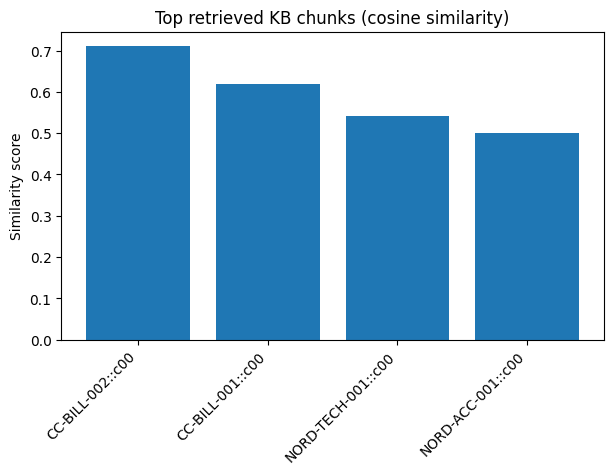

In [11]:
# Plot retrieval scores
plt.figure(figsize=(7,4))
plt.bar(retrieved["chunk_id"], retrieved["score"])
plt.xticks(rotation=45, ha="right")
plt.title("Top retrieved KB chunks (cosine similarity)")
plt.ylabel("Similarity score")
plt.show()


In [12]:
from google.genai import types
import datetime as dt
import time

def _extract_text_from_chunk(chunk) -> str:
    # Works across SDK variants where stream chunks may not have .text
    t = getattr(chunk, "text", None)
    if t:
        return t
    try:
        cand = chunk.candidates[0]
        content = cand.content
        parts = getattr(content, "parts", []) or []
        out = []
        for p in parts:
            pt = getattr(p, "text", None)
            if pt:
                out.append(pt)
        return "".join(out)
    except Exception:
        return ""

def _extract_text_from_response(resp) -> str:
    t = getattr(resp, "text", None)
    if t:
        return t
    try:
        cand = resp.candidates[0]
        parts = getattr(cand.content, "parts", []) or []
        out = []
        for p in parts:
            pt = getattr(p, "text", None)
            if pt:
                out.append(pt)
        return "".join(out)
    except Exception:
        return ""

def patched_respond_stream(self, session_id: str, user_message: str, customer_id: str = None):
    """
    Streaming: yields partial text strings.
    - Resolves any tool calls first (non-stream)
    - Streams final answer without tools enabled
    - Guarantees at least one yield (prevents Gradio StopAsyncIteration crash)
    """
    self._ensure_session(session_id)
    t0 = time.perf_counter()

    retrieved = retrieve(user_message, top_k=4)
    prompt = self._build_prompt(user_message, retrieved, customer_id)

    history = list(self.sessions[session_id])
    history.append(types.Content(role="user", parts=[types.Part(text=prompt)]))

    # Resolve tool calls first (non-stream)
    response = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_TOOLS)
    tools_executed = self._append_tool_results(history, response)

    rounds = 0
    while (getattr(response, "function_calls", None) or []) and rounds < 3:
        rounds += 1
        response = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_TOOLS)
        tools_executed += self._append_tool_results(history, response)

    # IMPORTANT: yield at least once so Gradio doesn't crash
    yielded_any = False
    partial = []
    yield ""  # first chunk (safe no-op UI-wise)

    # Stream final answer (no tools)
    for chunk in client.models.generate_content_stream(model=MODEL_ID, contents=history, config=GEN_CONFIG_NO_TOOLS):
        txt = _extract_text_from_chunk(chunk)
        if txt:
            partial.append(txt)
            yielded_any = True
            yield "".join(partial)

    # Fallback: if the stream yielded no text, do a single non-stream call and yield that
    if not yielded_any:
        final_resp = client.models.generate_content(model=MODEL_ID, contents=history, config=GEN_CONFIG_NO_TOOLS)
        final_text = _extract_text_from_response(final_resp)
        yield final_text

    # Save state + log
    self.sessions[session_id] = history
    t1 = time.perf_counter()
    self.logs.append({
        "ts": dt.datetime.now(dt.timezone.utc).isoformat(),
        "session_id": session_id,
        "user_len": len(user_message),
        "rounds": rounds,
        "top_score": float(retrieved["score"].max()),
        "latency_s": t1 - t0,
        "tools_called": tools_executed,
    })


CyberCareSupportAssistant.respond_stream = patched_respond_stream
print("Patched respond_stream ✅")


Patched respond_stream ✅


In [13]:
import gradio as gr

def chat_fn(message, history):
    msg = message["text"] if isinstance(message, dict) else message
    reply, _ = assistant.respond("gradio", msg, customer_id="cust_001")
    return reply

demo = gr.ChatInterface(
    fn=chat_fn,
    title="CyberCare Support Assistant",
)

demo.launch(debug=True, show_error=True)




It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1b0bd91fc592f98610.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1b0bd91fc592f98610.gradio.live


In [14]:
# analitika
logs_df = pd.DataFrame(assistant.logs)
logs_df


,ts,session_id,user_len,rounds,top_score,latency_s,tools_called
0,2026-02-03T00:29:53.552581+00:00,demo,79,1,0.710389,2.046630,1
1,2026-02-03T00:30:14.457367+00:00,gradio,99,1,0.684189,1.797227,1


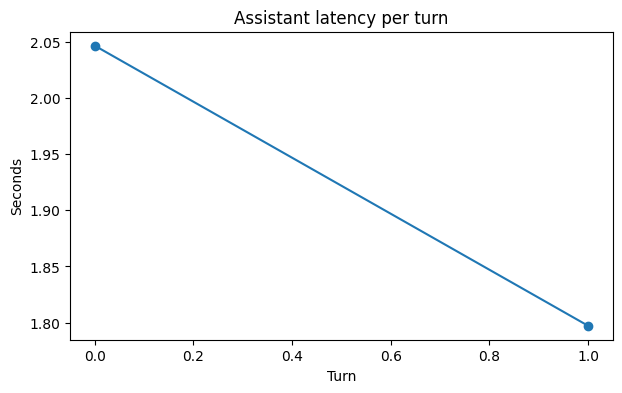

In [15]:
# delsa
plt.figure(figsize=(7,4))
plt.plot(logs_df["latency_s"].values, marker="o")
plt.title("Assistant latency per turn")
plt.xlabel("Turn")
plt.ylabel("Seconds")
plt.show()


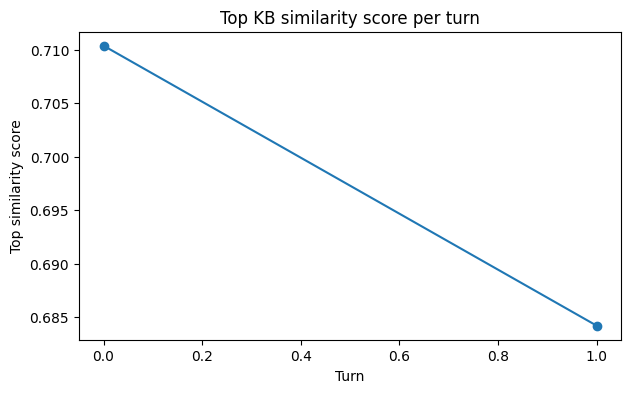

In [16]:
# tikrina KB duomenu artuma su naudotojo prompt
plt.figure(figsize=(7,4))
plt.plot(logs_df["top_score"].values, marker="o")
plt.title("Top KB similarity score per turn")
plt.xlabel("Turn")
plt.ylabel("Top similarity score")
plt.show()
